### Test the trained AutoEncoder

In [2]:
!pip install einops

   ---------------------------------------- 0.0/43.2 kB ? eta -:--:--
   ------------------------------------- -- 41.0/43.2 kB 1.9 MB/s eta 0:00:01
   ---------------------------------------- 43.2/43.2 kB 1.0 MB/s eta 0:00:00


In [4]:
!pip install timm

     ---------------------------------------- 0.0/47.5 kB ? eta -:--:--
     ------------------------ ------------- 30.7/47.5 kB 660.6 kB/s eta 0:00:01
     ---------------------------------------- 47.5/47.5 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.3 MB 14.2 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 37.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/402.6 kB ? eta -:--:--
   ---------------------------------- ----- 348.2/402.6 kB ? eta -:--:--
   ---------------------------------------- 402.6/402.6 kB 6.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/287.3 kB ? eta -:--:--
   ---------------------------------------- 287.3/287.3 kB ? eta 0:00:00


In [2]:
!pip install opencv-python-headless==4.5.3.56

     ---------------------------------------- 0.0/89.2 MB ? eta -:--:--
     --------------------------------------- 0.0/89.2 MB 682.7 kB/s eta 0:02:11
     ---------------------------------------- 0.1/89.2 MB 2.1 MB/s eta 0:00:42
     ---------------------------------------- 0.5/89.2 MB 5.0 MB/s eta 0:00:18
     ---------------------------------------- 0.9/89.2 MB 6.8 MB/s eta 0:00:13
      --------------------------------------- 1.3/89.2 MB 7.4 MB/s eta 0:00:12
      --------------------------------------- 1.7/89.2 MB 8.3 MB/s eta 0:00:11
      --------------------------------------- 2.2/89.2 MB 9.2 MB/s eta 0:00:10
     - -------------------------------------- 2.6/89.2 MB 9.7 MB/s eta 0:00:09
     - -------------------------------------- 3.0/89.2 MB 9.6 MB/s eta 0:00:09
     - -------------------------------------- 3.5/89.2 MB 10.0 MB/s eta 0:00:09
     - -------------------------------------- 3.9/89.2 MB 10.4 MB/s eta 0:00:09
     - -------------------------------------- 4.4/89.2 M

  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [342 lines of output]
      Ignoring numpy: markers 'python_version == "3.6" and platform_machine != "aarch64" and platform_machine != "arm64"' don't match your environment
      Ignoring numpy: markers 'python_version >= "3.6" and sys_platform == "linux" and platform_machine == "aarch64"' don't match your environment
      Ignoring numpy: markers 'python_version >= "3.6" and sys_platform == "darwin" and platform_machine == "arm64"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_machine != "aarch64" and platform_machine != "arm64"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.8" and platform_machine != "aarch64" and platform_machine != "arm64"' don't match your environment
        Using cached setuptools-70.2.0-py3-none-any.whl.metadata (5.8 kB)
        Using cache

In [3]:
!pip install Pillow==8.4.0

     ---------------------------------------- 0.0/49.4 MB ? eta -:--:--
     --------------------------------------- 0.0/49.4 MB 640.0 kB/s eta 0:01:18
     ---------------------------------------- 0.2/49.4 MB 2.8 MB/s eta 0:00:18
     ---------------------------------------- 0.6/49.4 MB 5.1 MB/s eta 0:00:10
      --------------------------------------- 1.0/49.4 MB 7.0 MB/s eta 0:00:07
     - -------------------------------------- 1.6/49.4 MB 9.0 MB/s eta 0:00:06
     - -------------------------------------- 2.2/49.4 MB 10.8 MB/s eta 0:00:05
     -- ------------------------------------- 3.0/49.4 MB 11.8 MB/s eta 0:00:04
     --- ------------------------------------ 3.9/49.4 MB 13.7 MB/s eta 0:00:04
     --- ------------------------------------ 4.9/49.4 MB 15.8 MB/s eta 0:00:03
     ----- ---------------------------------- 6.2/49.4 MB 18.1 MB/s eta 0:00:03
     ------ --------------------------------- 7.8/49.4 MB 20.7 MB/s eta 0:00:03
     ------- -------------------------------- 9.5/49

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [187 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\PIL
      copying src\PIL\BdfFontFile.py -> build\lib.win-amd64-cpython-311\PIL
      copying src\PIL\BlpImagePlugin.py -> build\lib.win-amd64-cpython-311\PIL
      copying src\PIL\BmpImagePlugin.py -> build\lib.win-amd64-cpython-311\PIL
      copying src\PIL\BufrStubImagePlugin.py -> build\lib.win-amd64-cpython-311\PIL
      copying src\PIL\ContainerIO.py -> build\lib.win-amd64-cpython-311\PIL
      copying src\PIL\CurImagePlugin.py -> build\lib.win-amd64-cpython-311\PIL
      copying src\PIL\DcxImagePlugin.py -> build\lib.win-amd64-cpython-311\PIL
      copying src\PIL\DdsImagePlugin.py -> build\lib.win-amd64-cpython-311\PIL
      copying src\PIL\EpsImagePlugin.

In [4]:
!pip install tensorflow==2.7.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.7.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0)
ERROR: No matching distribution found for tensorflow==2.7.0


In [ ]:
!pip install timm==0.4.12

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

from pathlib import Path
import random
from datetime import datetime

from matplotlib import pyplot as plt

from model import VPTREnc, VPTRDec, VPTRDisc, init_weights
from model import GDL, MSELoss, L1Loss, GANLoss
from utils import KTHDataset, BAIRDataset, MovingMNISTDataset
from utils import VidCenterCrop, VidPad, VidResize, VidNormalize, VidReNormalize, VidCrop, VidRandomHorizontalFlip, VidRandomVerticalFlip, VidToTensor
from utils import visualize_batch_clips, save_ckpt, load_ckpt, set_seed, AverageMeters, init_loss_dict, write_summary, resume_training
from utils import set_seed, get_dataloader

set_seed(2021)

ModuleNotFoundError: No module named 'timm'

In [2]:
resume_ckpt = Path('/home/MovingMNIST_AE.tar') #specify your trained autoencoder checkpoint file
num_past_frames = 10
num_future_frames = 10
encH, encW, encC = 8, 8, 528
img_channels = 1 #Set to be 3 for BAIR dataset
N = 16
device = torch.device('cuda:0')
loss_name_list = ['AE_L1', 'Dtotal', 'Dfake', 'Dreal', 'AEgan']

In [3]:
VPTR_Enc = VPTREnc(img_channels, feat_dim = encC, n_downsampling = 3, padding_type = 'reflect').to(device) #Set the padding_type to be "zero" for BAIR dataset

#Set the padding_type to be "zero" for BAIR dataset, set the out_layer to be 'Sigmoid' for MovingMNIST
VPTR_Dec = VPTRDec(img_channels, feat_dim = encC, n_downsampling = 3, out_layer = 'Sigmoid', padding_type = 'reflect').to(device) 

init_weights(VPTR_Enc)
init_weights(VPTR_Dec)

loss_dict, start_epoch = resume_training({'VPTR_Enc': VPTR_Enc, 'VPTR_Dec': VPTR_Dec}, 
                                         {}, resume_ckpt, loss_name_list)

initialize network with normal
initialize network with normal


In [4]:
_, _, test_loader, renorm_transform = get_dataloader('MNIST', N, '/home/MovingMNIST', test_past_frames = 10, test_future_frames = 10, ngpus = 1, num_workers = 1)

In [5]:
model = nn.Sequential(VPTR_Enc, VPTR_Dec)

In [6]:
sample = next(iter(test_loader))
past_frames, future_frames = sample
past_frames = past_frames.to(device)
future_frames = future_frames.to(device)
x = torch.cat([past_frames, future_frames], dim = 1 )
pred = model(x)

In [7]:
def plot_model_result(pred, fig_name, num_frames, n = 2):
    fig, ax = plt.subplots(1, num_frames, figsize = (num_frames, 1))
    fig.subplots_adjust(wspace=0., hspace = 0.)

    for j in range(num_frames):
        ax[j].set_axis_off()
        
        img = pred[:, j, :, :, :].clone()
        img = renorm_transform(img)
        img = torch.clamp(img, min = 0., max = 1.)
        img = img[n, ...]

        img = transforms.ToPILImage()(img)
        ax[j].imshow(img, cmap = 'gray')
    fig.savefig(f'{fig_name}.pdf', bbox_inches = 'tight')

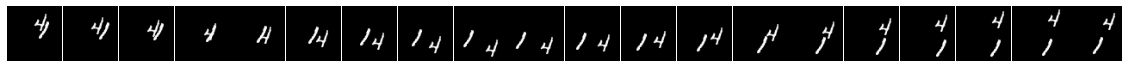

In [8]:
plot_model_result(x, 'AE_gt', 20, n = 1)

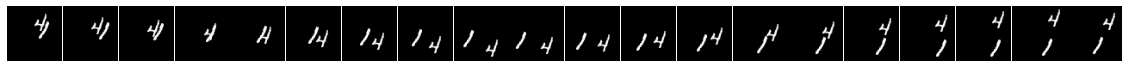

In [9]:
plot_model_result(pred, 'AE_rec', 20, n = 1)